##### Copyright 2020 The TensorFlow Authors.

In [24]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Spectogram 기반 욕설 키워드 인식

이 코드에서는 <a href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/audio/simple_audio.ipynb" class="external">TensorFlow 키워드 인식 튜토리얼</a> 을 베이스 라인으로 자동 음성 인식 모델을 구축합니다. 모델은 '씨발', '개새끼', '기타' 3가지 클래스를 분류합니다.  '씨발' 과 '개새끼' 는 직접 녹음한 2초의 오디오를 사용합니다. '기타'에는 직접 녹음한 음성과 <a href="https://github.com/karolpiczak/ESC-50" class="external">ESC-50 environmental audio recordings</a> , <a href="https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=data&dataSetSn=537" class="external">AI 허브 화자 인식용 음성 데이터</a>를 2초로 자른 음성을 사용합니다. 

## 설정

필요한 모듈과 종속성을 가져옵니다. 이 튜토리얼에서는 시각화를 위해 <a href="https://seaborn.pydata.org/" class="external">seaborn</a>을 사용할 것입니다.

In [25]:
import os
import pathlib
import soundfile as sf
import wave 
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf
import librosa
from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display
import glob 
from pathlib import Path
from pydub import AudioSegment
from scipy.io import wavfile

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

## 데이터세트 가져오기
데이터세트의 오디오 클립은 각 음성 명령에 해당하는 3개의 폴더(gaesaekki, shibal, others)에 저장합q니다.

In [26]:
DATASET_PATH = 'dataset_final'

data_dir = pathlib.Path(DATASET_PATH)

In [27]:
classes = np.array(tf.io.gfile.listdir(str(data_dir)))
classes = classes[classes != 'README.md']
print('classes:', classes)

classes: ['gaesaekki' 'others' 'shibal']


데이터 셋을 모델이 인식할 수 있는 형태로 전처리 하여 '16bit_dataset' 이라는 폴더에 저장합니다

In [28]:
def change_audio_properties(input_file, output_file):
    # 파일 로드
    audio = AudioSegment.from_file(input_file)

    # 모노 채널로 변경
    mono_audio = audio.set_channels(1)

    # 샘플레이트 변경
    resampled_audio = mono_audio.set_frame_rate(16000)

    # 16비트로 변경
    sixteen_bit_audio = resampled_audio.set_sample_width(2)

    # 음성 길이를 2초로 조정
    audio_length = 2000  # 2초
    if len(sixteen_bit_audio) > audio_length:
        # 음성이 2초보다 길면 앞에서부터 잘라내기
        sixteen_bit_audio = sixteen_bit_audio[:audio_length]
    else:
        # 음성이 2초보다 짧으면 뒷부분을 silence로 채우기
        silence = AudioSegment.silent(duration=audio_length - len(sixteen_bit_audio))
        sixteen_bit_audio = sixteen_bit_audio + silence

    # 파일을 wav 형식으로 저장
    sixteen_bit_audio.export(output_file, format="wav")

In [29]:
# 음성을 16 비트 데이터셋으로 변환
wav_files = glob.glob(os.path.join(data_dir, '*' ,'*.wav'))
for wav_file in wav_files: 
    output_file_path = wav_file.replace('dataset_final', '16bit_dataset')
    if not os.path.exists(os.path.dirname(output_file_path)):
        os.makedirs(os.path.dirname(output_file_path))

    change_audio_properties(wav_file, output_file_path)
print("음성 파일 변환 완료")


음성 파일 변환 완료


In [30]:
DATASET_PATH = 'C:\\Users\\wise_\\pj2\\simple_audio_20231128\\16bit_dataset'

data_dir = Path(DATASET_PATH)


In [31]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/classes[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 9492
Number of examples per label: 2876
Example file tensor: tf.Tensor(b'C:\\Users\\wise_\\pj2\\simple_audio_20231128\\16bit_dataset\\shibal\\augmented_KDY_46.wav', shape=(), dtype=string)


 `filenames` 를  training, validation and test sets로 85:10:5 비율로 나눕니다. 

In [32]:
num_samples = len(filenames)
train_set = int(num_samples*0.8)
test_set = int(num_samples*0.95)


train_files = filenames[:train_set]
val_files = filenames[train_set: test_set]
test_files = filenames[test_set: ]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 7593
Validation set size 1424
Test set size 475


## Read the audio files and their labels

파형 및 해당 레이블에 대한 디코딩된 텐서를 생성하여 데이터셋을 전처리 합니다.

In [33]:
# 샘플 파일 정보 확인
sample_file = '16bit_dataset\gaesaekki\hj_3.wav'
test_file = tf.io.read_file(sample_file)
test_audio, _ = tf.audio.decode_wav(contents=test_file)
test_audio.shape

TensorShape([32000, 1])

In [34]:
# WAV 파일 정보 확인
with wave.open(sample_file, 'rb') as wf:
    print("Number of channels:", wf.getnchannels())
    print("Sample width (bytes):", wf.getsampwidth())

    # 샘플 폭이 2바이트(16비트)인지 확인
    if wf.getsampwidth() == 2:
        print("This is a 16-bit WAV file.")
    else:
        print("This is not a 16-bit WAV file.")
    
    print("Sample rate:", wf.getframerate())


Number of channels: 1
Sample width (bytes): 2
This is a 16-bit WAV file.
Sample rate: 16000


 데이터셋의 원시 WAV 오디오 파일을 오디오 텐서로 전처리하는 함수 정의

In [35]:
def decode_audio(audio_binary):
  # tf.audio.decode_wav 함수를 사용하여 WAV 형식의 오디오 파일을 디코딩
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  # 모든 데이터가 단일 채널(모노)이므로 배열에서 `channels` 축을 제거
  # 오디오 데이터의 형태는 [num_frames, num_channels], 모든 데이터가 1채널이므로 마지막 축 제거 (유연한 관리를 위해)
  return tf.squeeze(audio, axis=-1)

각 파일의 상위 디렉토리를 사용하여 레이블을 생성하는 함수 정의 
- 파일 경로를  'tf.RaggedTensor'(길이 다를 수 있는 조각이 있는 치수의 텐서)로 분할합니다.

In [36]:
# 파일 경로 끝에서 두 번째를 따와서 label 로 만든다. 
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  # '/path/to/dataset/class1/file.wav' 라면 class1 을 라벨로 가져옵니다. 
  return parts[-2]

`get_waveform_and_label` 함수 정의 : 

- input : .wav 오디오 파일 이름 
- output : 학습을 위해 준비된 오디오 및 라벨 텐서를 포함하는 튜플

In [37]:
def get_waveform_and_label(file_path):
  # 파일 경로로부터 레이블을 얻어옴
  label = get_label(file_path)
  # tf.io.read_file 함수를 사용하여 파일에서 오디오 이진 데이터를 읽어옴
  audio_binary = tf.io.read_file(file_path)
  # 읽어온 이진 데이터를 디코딩하여 오디오 데이터를 얻어옴
  waveform = decode_audio(audio_binary)
  return waveform, label

앞에서 정의한 'get_waveform_and_label'을 사용하여 'Dataset.from_tensor_slices'와 'Dataset.map'으로 'tf.data.Dataset'을 생성합니다. 

In [38]:
# 데이터 입력 파이프라인의 성능을 최적화하기 위해 사용하는 상수, 병렬 처리 및 버퍼링을 조절
AUTOTUNE = tf.data.AUTOTUNE

# train_files 리스트를 기반으로 TensorFlow 데이터셋을 생성
files_ds = tf.data.Dataset.from_tensor_slices(train_files)

# map 함수를 사용하여 각 파일에 대해 get_waveform_and_label 함수를 적용
# num_parallel_calls를 사용하여 병렬 처리 수행

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)



#  waveform_ds는 각 파일에 대한 오디오 데이터와 레이블을 포함하는 TensorFlow 데이터셋 waveform_ds 완성 ! 

Let's plot a few audio waveforms:

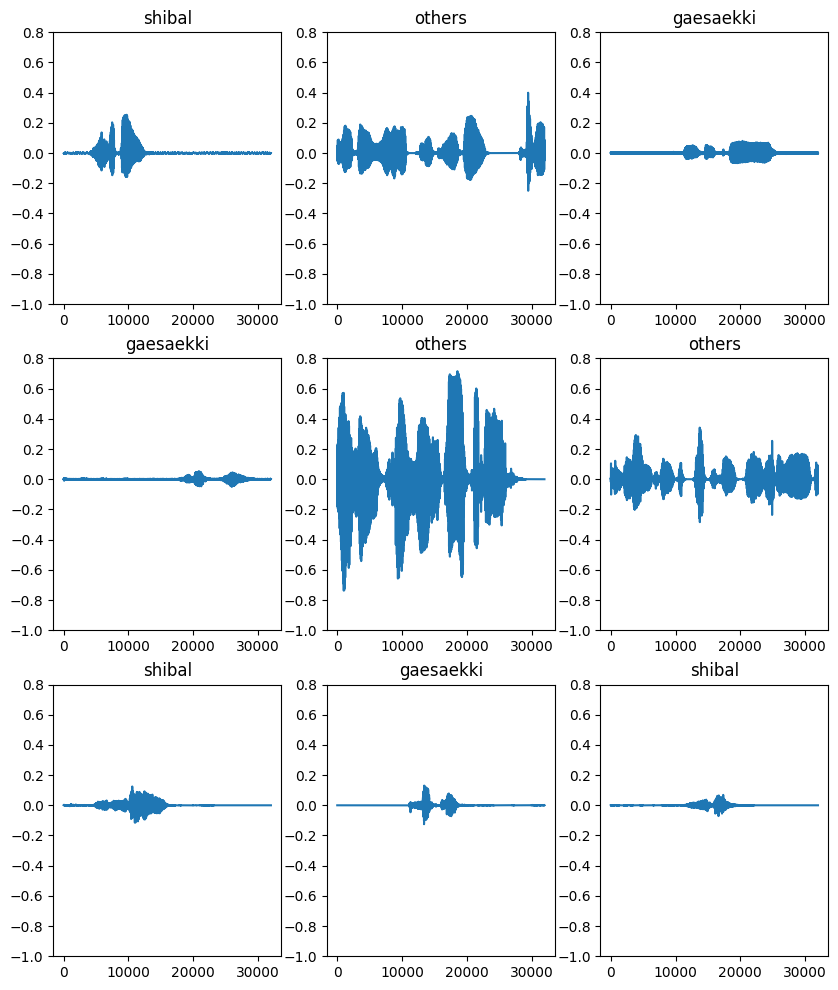

In [39]:
rows = 3
cols = 3
n = rows * cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))

for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.0, 1.0, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## 파형을 스펙트로그램으로 변환하기

데이터세트의 파형은 시간 영역에서 표시됩니다. 다음으로, 시간-영역 신호의 파형을 시간-주파수-영역 신호로 변환합니다. 이를 위해 <a href="https://en.wikipedia.org/wiki/Short-time_Fourier_transform" class="external">STFT(short-time Fourier transform)</a>를 계산하여 시간에 따른 주파수 변화를 보여주고 2D 이미지로 나타낼 수 있는 <a href="https://en.wikipedia.org/wiki/Spectrogram" clas="external">스펙트로그램</a>으로 파형을 변환합니다. 스펙트로그램 이미지를 신경망에 공급하여 모델을 훈련시킵니다.

퓨리에 변환(`tf.signal.fft`)은 신호를 성분 주파수로 변환하지만 모든 시간 정보는 손실됩니다. 이에 비해 STFT(`tf.signal.stft`)는 신호를 시간 창으로 분할하고 각 창에서 퓨리에 변환을 실행하여 일부 시간 정보를 보존하고 표준 콘볼루션을 실행할 수 있는 2D 텐서를 반환합니다.

파형을 스펙트로그램으로 변환하기 위한 유틸리티 함수를 생성합니다.

- 파형은 길이가 같아야 스펙트로그램으로 변환할 때 결과가 비슷한 차원을 갖게 됩니다. 이를 위해 1초보다 짧은 오디오 클립을 단순히 0으로 채울 수 있습니다(`tf.zeros` 사용).
- `tf.signal.stft`를 호출할 때 생성된 스펙트로그램 "이미지"가 거의 정사각형이 되도록 `frame_length` 및 `frame_step` 매개변수를 선택합니다. STFT 매개변수 선택에 대한 자세한 내용은 오디오 신호 처리 및 STFT에 대한 <a href="https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe" class="external">이 Coursera 비디오</a>를 참조하세요.
- STFT는 크기와 위상을 나타내는 복소수 배열을 생성합니다. 그러나 이 튜토리얼에서는 `tf.abs`의 출력에 `tf.signal.stft`를 적용하여 유도할 수 있는 크기만 사용합니다.

In [40]:
def get_spectrogram(waveform):
  # Convert the waveform to a spectrogram via a STFT.
  spectrogram = tf.signal.stft(
      waveform, frame_length=255, frame_step=128)
  # Obtain the magnitude of the STFT.
  spectrogram = tf.abs(spectrogram)
  # Add a `channels` dimension, so that the spectrogram can be used
  # as image-like input data with convolution layers (which expect
  # shape (`batch_size`, `height`, `width`, `channels`).
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

예제 파일의 라벨, 텐서화된 Waveform 과 해당하는 스펙토그램의 모양을 인쇄하고 원본 오디오를 재생합니다.

In [41]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

s_shape = spectrogram.shape

Label: shibal
Waveform shape: (32000,)
Spectrogram shape: (249, 129, 1)
Audio playback


스펙트로그램을 표시하기 위한 함수를 정의합니다

In [42]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  # Convert the frequencies to log scale and transpose, so that the time is
  # represented on the x-axis (columns).
  # Add an epsilon to avoid taking a log of zero.
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

시간에 따른 예제의 파형과 해당하는 스펙트로그램(시간에 따른 주파수)을 플롯합니다

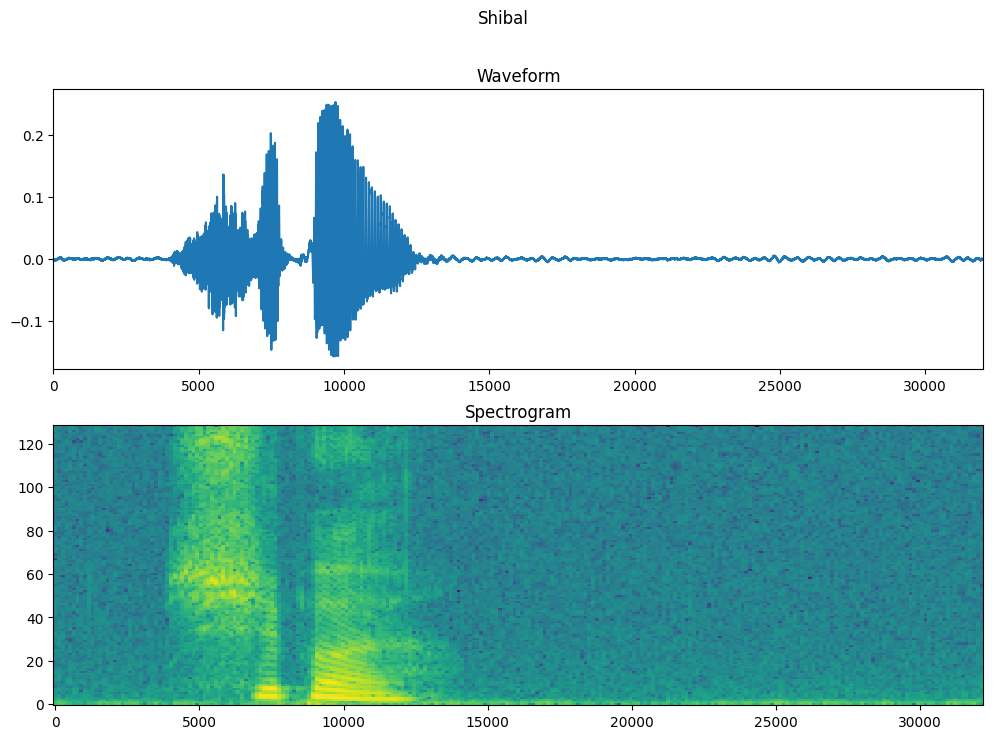

In [43]:
fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000*2])

plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.suptitle(label.title())
plt.show()

Wavefrom 데이터 세트를 스펙트로그램으로 변환합니다. 일부 스펙트로그램의 길이가 다른 부분이 있어 pad or crop 함수를 추가로 정의힙니다. 레이블을 정수 ID로 변환하는 함수를 정의합니다.

In [1]:

def pad_or_crop_to_expected_size(spectrogram):
  EXPECTED_SPECTROGRAM_LENGTH = 249
  spectrogram_length = tf.shape(spectrogram)[0]
  # 패딩 또는 잘라내기를 수행하여 스펙트로그램의 길이를 EXPECTED_SPECTROGRAM_LENGTH로 조정
  if spectrogram_length < EXPECTED_SPECTROGRAM_LENGTH:
    # 시간축이 짧으면 나머지를 0으로 패딩
    padding = EXPECTED_SPECTROGRAM_LENGTH - spectrogram_length
    spectrogram = tf.pad(spectrogram, [[0, padding], [0, 0], [0, 0]])
  else:
    # 시간축이 길면 초과하는 부분을 잘라냄
    spectrogram = spectrogram[:EXPECTED_SPECTROGRAM_LENGTH, :]
  return spectrogram


In [45]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = pad_or_crop_to_expected_size(spectrogram)
  label_id = tf.math.argmax(label == classes)
  return spectrogram, label_id

'Dataset.map'을 사용하여 데이터셋의 요소에 'get_spectrogram_and_label_id'를 매핑합니다:

In [46]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

데이터 세트의 다양한 예에 대한 스펙트로그램을 확인합니다:


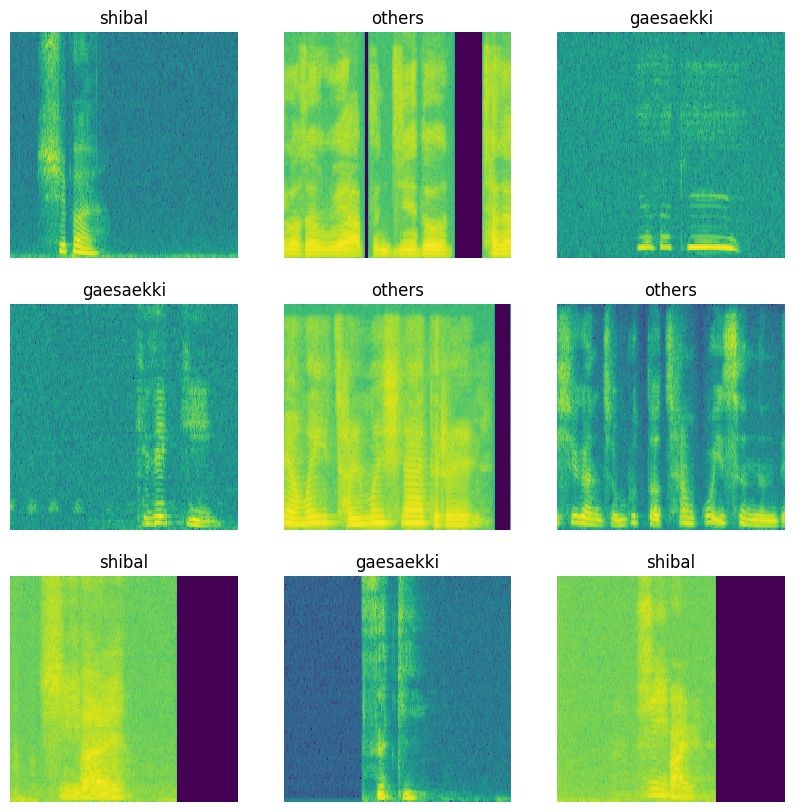

In [47]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))

for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(spectrogram.numpy(), ax)
  ax.set_title(classes[label_id.numpy()])
  ax.axis('off')

plt.show()

## 모델 빌드 및 훈련하기
Repeat the training set preprocessing on the validation and test sets:

In [48]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [49]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Batch the training and validation sets for model training:

In [50]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Add `Dataset.cache` and `Dataset.prefetch` operations to reduce read latency while training the model:

In [51]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

이 모델의 경우, 오디오 파일을 스펙트로그램 이미지로 변환했으므로 간단한 콘볼루션 신경망(CNN)을 사용합니다.

`tf.keras.Sequential` 모델은 다음과 같은 Keras 전처리 레이어를 사용합니다.

- `tf.keras.layers.Resizing`: 모델이 더 빨리 학습할 수 있도록 입력을 다운샘플링합니다.
- `tf.keras.layers.Normalization`: 평균과 표준 편차를 기반으로 이미지의 각 픽셀을 정규화합니다.

`Normalization` 레이어의 경우, 집계 통계(즉, 평균 및 표준 편차)를 계산하기 위해 먼저 훈련 데이터에 대해 해당 `adapt` 메서드를 호출해야 합니다.

In [52]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(classes)

# Instantiate the `tf.keras.layers.Normalization` layer.
norm_layer = layers.Normalization()
# Fit the state of the layer to the spectrograms
# with `Normalization.adapt`.
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    # Downsample the input.
    layers.Resizing(32, 32),
    # Normalize.
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(128, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(256, 3, activation='relu'), 
    layers.MaxPooling2D(),
    layers.Dropout(0.5),
    layers.Flatten(),
    layers.Dense(128, activation='elu'),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (249, 129, 1)


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 32, 32, 1)         0         
                                                                 
 normalization (Normalizati  (None, 32, 32, 1)         3         
 on)                                                             
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)        0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)         

Configure the Keras model with the Adam optimizer and the cross-entropy loss:

In [53]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

모델 학습 시작. 과적합 방지를 위해  Early Stopping 콜백에 의해 검증 손실이 2 Epoch 연속으로 감소하지 않으면 훈련이 조기에 중지

In [54]:
EPOCHS = 30
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/30


119/119 [==============================] - 10s 81ms/step - loss: 0.4823 - accuracy: 0.8064 - val_loss: 0.2093 - val_accuracy: 0.9213
Epoch 2/30
119/119 [==============================] - 5s 45ms/step - loss: 0.2158 - accuracy: 0.9290 - val_loss: 0.1388 - val_accuracy: 0.9480
Epoch 3/30
119/119 [==============================] - 5s 44ms/step - loss: 0.1538 - accuracy: 0.9443 - val_loss: 0.1329 - val_accuracy: 0.9572
Epoch 4/30
119/119 [==============================] - 5s 45ms/step - loss: 0.1171 - accuracy: 0.9589 - val_loss: 0.0947 - val_accuracy: 0.9691
Epoch 5/30
119/119 [==============================] - 5s 44ms/step - loss: 0.0980 - accuracy: 0.9664 - val_loss: 0.0688 - val_accuracy: 0.9782
Epoch 6/30
119/119 [==============================] - 5s 44ms/step - loss: 0.0748 - accuracy: 0.9756 - val_loss: 0.0778 - val_accuracy: 0.9775
Epoch 7/30
119/119 [==============================] - 5s 44ms/step - loss: 0.0676 - accuracy: 0.9768 - val_loss: 0.0603 - val_accuracy: 0.9

Let's plot the training and validation loss curves to check how your model has improved during training:

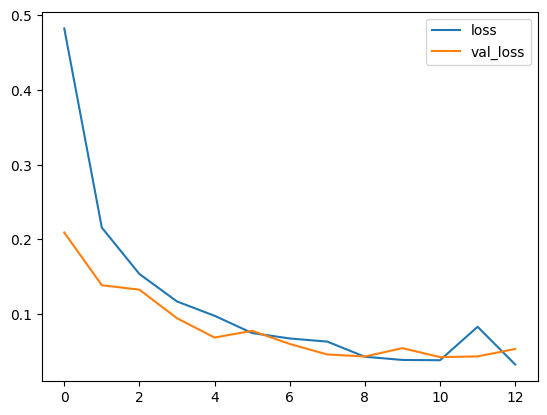

In [55]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Evaluate the model performance

Run the model on the test set and check the model's performance:

In [56]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [57]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

15/15 [==============================] - 0s 8ms/step
Test set accuracy: 98%


### Display a confusion matrix

Use a <a href="https://developers.google.com/machine-learning/glossary#confusion-matrix" class="external">confusion matrix</a> to check how well the model did classifying each of the commands in the test set:


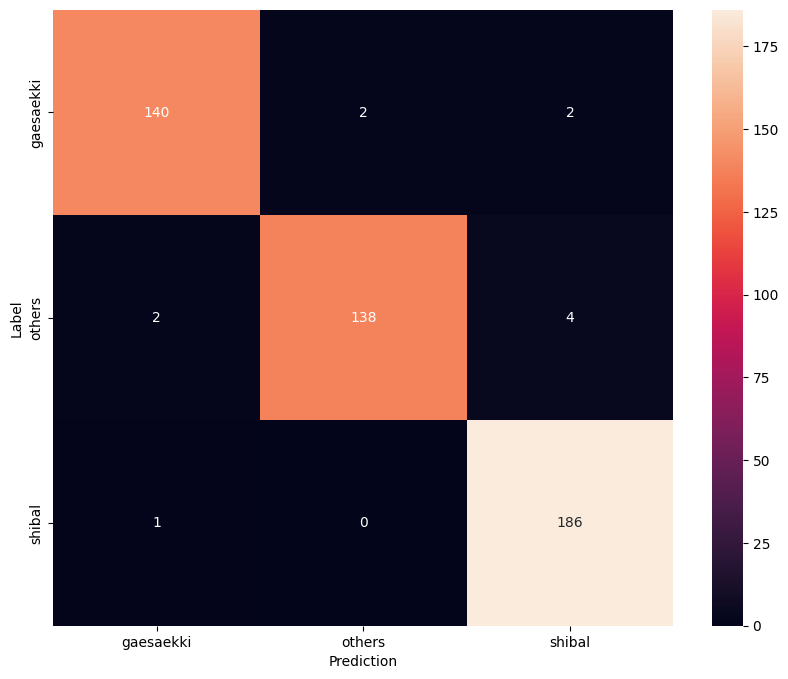

In [58]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx,
            xticklabels=classes,
            yticklabels=classes,
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

In [59]:
model.save("saved_model_test")

INFO:tensorflow:Assets written to: saved_model_test\assets


INFO:tensorflow:Assets written to: saved_model_test\assets
